In [1]:
import os
import sys
import numpy as np
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
# import cartopy.feature as feat
import xrft
from scipy import constants as co
from scipy import fft
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import IPython.display as disp
from metpy import calc as mcalc
from metpy import interpolate as minterpolate
from metpy.units import units
import pandas as pd
import time
from ipywidgets import IntProgress, HTML
import shutil
from cdo import Cdo
from nco import Nco

plt.rcParams['animation.ffmpeg_path'] = '/home/hugo/mambaforge-pypy3/envs/env/bin/ffmpeg'
cdo = Cdo()
nco = Nco()
%matplotlib inline

In [2]:
DATADIR = "/scratch2/hugo/ERA5"
CLIMSTOR = "/mnt/climstor/ecmwf/era5/raw"

def filenamescm(y, m, d):  # Naming conventions of the files on climstor (why are they so different?)
    return [f"{CLIMSTOR}/ML/data/{str(y)}/P{str(y)}{str(m).zfill(2)}{str(d).zfill(2)}_{str(h).zfill(2)}" for h in range(0, 24, 6)]
def filenamecp(y, m, d):
    return [f"{CLIMSTOR}/PL/data/an_pl_ERA5_{str(y)}-{str(m).zfill(2)}-{str(d).zfill(2)}.nc"]  # returns iterable to have same call signature as filenamescl(y, m, d)
def filenamegeneric(y, m, folder):
    return [f"{DATADIR}/{folder}/{y}{str(m).zfill(2)}.nc"]

def _fn(date, which):
    if which == "ML":
        return filenamescm(date.year, date.month, date.day)
    elif which == "PL":
        return filenamecp(date.year, date.month, date.day)
    else:
        return filenamegeneric(date.year, date.month, which)
    
def fn(date, which):  # instead takes pandas.timestamp (or iterable of _) as input
    if isinstance(date, (list, np.ndarray, pd.DatetimeIndex)):
        filenames = []
        for d in date:
            filenames.extend(_fn(d, which))
        return filenames
    elif isinstance(date, pd.Timestamp):
        return _fn(date, which)
    else:
        raise RuntimeError(f"Invalid type : {type(date)}")

RADIUS = 6.371e6  # m
OMEGA = 7.2921e-5  # rad.s-1
KAPPA = 0.2854
R_SPECIFIC_AIR = 287.0500676

def degcos(x):
    return np.cos(x / 180 * np.pi)
def degsin(x):
    return np.sin(x / 180 * np.pi)

DATERANGEPL = pd.date_range("19590101", "20211231")
YEARSPL = np.unique(DATERANGEPL.year)
DATERANGEML = pd.date_range("19770101", "20211231")

### JLI computations on scratch/ERA5/Wind/ files, following Woollings et al. 2010 + Barriopedro et al. 2022

In [3]:
# Step 1 : extraction of daily mean zonal wind, averaged over 4 p levels
files = np.asarray([filenamegeneric(y, m, "Woollings_daily") for y in YEARSPL for m in range(1, 13)]).flatten()
da = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"]

In [4]:
# Lanczos filtering
def low_pass_weights(window, cutoff):  # shamefully stolen from https://github.com/liv0505/Lanczos-Filter
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

window = 61
weights = xr.DataArray(low_pass_weights(window, 1 / 10), dims=["window"])
da2 = da.rolling(time=len(weights), center=True).construct("window").dot(weights).isel(time=range(int(window / 2), len(da.time) - int(window / 2)))

In [52]:
da_fft = xrft.fft(da.chunk((23011, 1, 1)), dim="time")

In [53]:
da_fft

<xarray.DataArray (freq_time: 23011, lat: 121, lon: 1)>
dask.array<mul, shape=(23011, 121, 1), dtype=complex128, chunksize=(23011, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon        (lon) float64 0.0
  * lat        (lat) float64 15.0 15.5 16.0 16.5 17.0 ... 73.5 74.0 74.5 75.0
  * freq_time  (freq_time) float64 -5.787e-06 -5.786e-06 ... 5.786e-06 5.787e-06

In [71]:
da_fft[np.abs(da_fft.freq_time) > 1 / 10 / 24 / 3600] = 0
da3 = xrft.ifft(da_fft, dim="freq_time", true_phase=True, true_amplitude=True).real.assign_coords(time=da.time)

/home/hugo/mambaforge-pypy3/envs/env/lib/python3.9/site-packages/xrft/xrft.py:546: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


In [72]:
JL = da3.argmax(dim="lat", skipna=True).load()
JLI = da3.lat[JL][:, 0]
JLIg = JLI.groupby("time.dayofyear")
JLIsmooth = JLIg.mean(dim="time")

ft = fft.rfft(JLIsmooth.values)
ft[3:] = 0
JLIsmooth2 = xr.DataArray(fft.irfft(ft, len(JLIsmooth)), dims=JLIsmooth.dims)

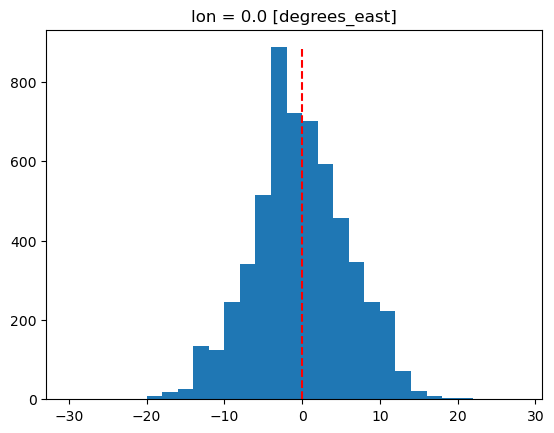

In [73]:
fig, ax = plt.subplots()
timeseries = (JLI.groupby("time.dayofyear") - JLIsmooth2)
timeseries = timeseries.isel(time=(timeseries.time.dt.season=="DJF"))
hist = xr.plot.hist(timeseries, ax=ax, bins=np.arange(-30, 30, 2))
ax.plot([0, 0], [0, np.max(hist[0])], "r--")
plt.show()

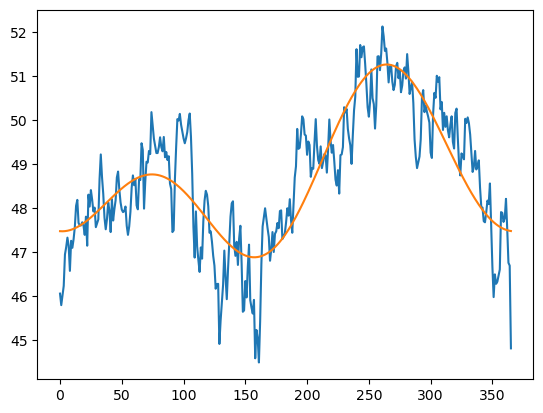

In [74]:
fig, ax = plt.subplots()
ax.plot(JLIsmooth)
ax.plot(JLIsmooth2)

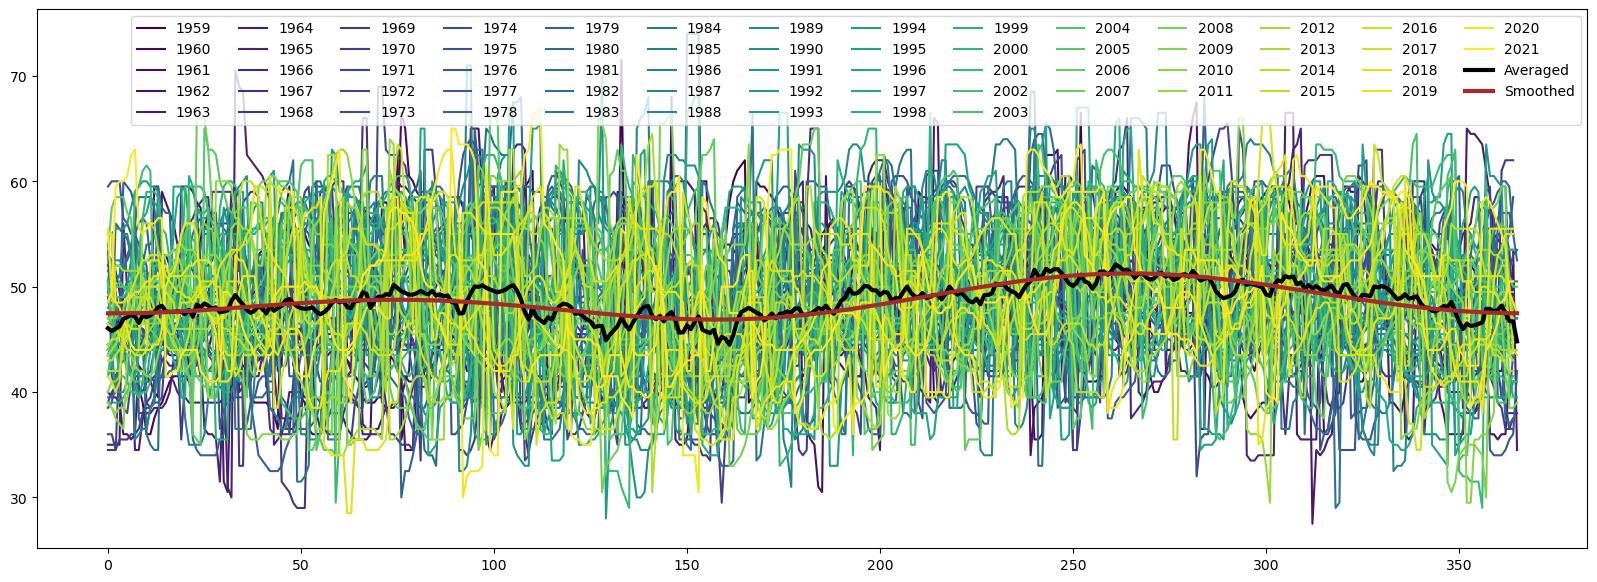

In [75]:
fig, ax = plt.subplots(figsize=(20,7))
groups = JLI.groupby("time.year")
ng = len(groups)
colors = plt.colormaps["viridis"](np.linspace(0, 1, ng))
for i, g in enumerate(groups):
    j, g = g
#     ax.plot(g.isel(time=(g.time.dt.season=="DJF")), label=j, color=colors[i])
    ax.plot(g, label=j, color=colors[i])
winter = np.logical_or(JLIsmooth2.dayofyear <= 366, JLIsmooth2.dayofyear >= 355)
ax.plot(JLIsmooth.isel(dayofyear=winter), lw=3, color="black", label="Averaged")
ax.plot(JLIsmooth2.isel(dayofyear=winter), lw=3, color="brown", label="Smoothed")
ax.legend(ncol=14)
plt.show()

In [18]:
JLIsmooth2

<xarray.DataArray (dayofyear: 366)>
array([47.42682839, 47.42426612, 47.42310483, 47.42332643, 47.42491117,
       47.42783776, 47.43208332, 47.43762346, 47.44443232, 47.45248257,
       47.46174547, 47.47219091, 47.48378745, 47.49650236, 47.51030166,
       47.52515017, 47.54101157, 47.55784842, 47.57562223, 47.59429351,
       47.61382183, 47.63416583, 47.65528334, 47.67713137, 47.69966622,
       47.7228435 , 47.74661822, 47.7709448 , 47.79577718, 47.82106886,
       47.84677293, 47.87284219, 47.89922916, 47.92588617, 47.9527654 ,
       47.97981896, 48.00699894, 48.03425747, 48.06154679, 48.08881931,
       48.11602766, 48.14312475, 48.17006386, 48.19679865, 48.22328326,
       48.24947236, 48.27532118, 48.30078561, 48.32582222, 48.35038833,
       48.37444207, 48.39794243, 48.42084929, 48.44312351, 48.46472695,
       48.48562253, 48.50577427, 48.52514734, 48.54370812, 48.56142422,
       48.57826451, 48.59419921, 48.60919987, 48.62323945, 48.63629234,
       48.64833437, 48.65934288, 48.66929673, 48.67817632, 48.68596363,
       48.69264224, 48.69819733, 48.70261575, 48.70588597, 48.70799816,
       48.70894416, 48.70871751, 48.70731346, 48.70472895, 48.70096266,
       48.69601498, 48.68988803, 48.68258564, 48.67411335, 48.66447843,
       48.65368983, 48.64175821, 48.62869589, 48.61451689, 48.59923684,
       48.58287303, 48.56544435, 48.54697129, 48.52747589, 48.50698175,
       48.48551396, 48.46309911, 48.43976523, 48.41554178, 48.39045957,
...
       51.19302489, 51.1812525 , 51.16762264, 51.1521521 , 51.13485951,
       51.11576533, 51.09489177, 51.07226284, 51.04790426, 51.02184347,
       50.99410958, 50.96473334, 50.93374708, 50.90118473, 50.86708173,
       50.831475  , 50.79440292, 50.75590525, 50.71602312, 50.67479894,
       50.63227642, 50.58850044, 50.54351705, 50.49737339, 50.45011768,
       50.4017991 , 50.3524678 , 50.30217477, 50.25097187, 50.19891169,
       50.14604754, 50.09243337, 50.03812371, 49.98317362, 49.92763861,
       49.8715746 , 49.81503782, 49.75808479, 49.70077223, 49.64315699,
       49.58529603, 49.52724629, 49.46906467, 49.41080798, 49.35253283,
       49.29429559, 49.23615234, 49.17815879, 49.12037021, 49.06284142,
       49.00562664, 48.94877953, 48.89235304, 48.83639943, 48.78097015,
       48.72611583, 48.67188619, 48.61833   , 48.56549505, 48.51342805,
       48.46217461, 48.4117792 , 48.36228508, 48.31373426, 48.26616746,
       48.21962406, 48.17414208, 48.12975809, 48.08650725, 48.04442318,
       48.00353802, 47.96388231, 47.92548504, 47.88837355, 47.85257354,
       47.81810907, 47.78500245, 47.75327434, 47.72294362, 47.69402743,
       47.66654117, 47.64049843, 47.61591103, 47.59278899, 47.57114052,
       47.55097205, 47.53228816, 47.51509166, 47.49938354, 47.48516298,
       47.47242738, 47.46117234, 47.45139169, 47.44307752, 47.43622013,
       47.43080813])
Dimensions without coordinates: dayofyear

### Barriopedro

In [4]:
files = np.asarray([filenamegeneric(y, m, "Barriopedro") for y in YEARSPL for m in range(1, 13)]).flatten()
da = xr.open_mfdataset(files, concat_dim="time", combine='nested', engine="netcdf4")["u"]

In [ ]:
one_ts = da.isel(lon=0, lat=0)
fft.fftfreqs

In [ ]:
# Step 3 : Lanczos filtering
def low_pass_weights(window, cutoff):  # shamefully stolen from https://github.com/liv0505/Lanczos-Filter
    """Calculate weights for a low pass Lanczos filter.
    Args:
    window: int
        The length of the filter window.
    cutoff: float
        The cutoff frequency in inverse time steps.
    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]

window = 61
weights = xr.DataArray(low_pass_weights(window, 1 / 10), dims=["window"])
da2 = da.rolling(time=len(weights), center=True).construct("window").dot(weights).isel(time=range(int(window / 2), len(da.time) - int(window / 2)))

In [23]:
### JLI
da_JLI = da.sel(lon=np.linspace(-60, 0, 0.5))

<xarray.DataArray 'u' (time: 23011, lat: 121, lon: 241)>
dask.array<concatenate, shape=(23011, 121, 241), dtype=float32, chunksize=(31, 121, 241), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01T09:00:00 ... 2021-12-31T09:00:00
  * lon      (lon) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 28.5 29.0 29.5 30.0
  * lat      (lat) float32 15.0 15.5 16.0 16.5 17.0 ... 73.0 73.5 74.0 74.5 75.0
Attributes:
    standard_name:  eastward_wind
    long_name:      U component of wind
    units:          m s**-1
    cell_methods:   time: mean
    institution:    ECMWF

### PV calculation on a PL file from climstor

In [20]:
ds = xr.open_mfdataset(fn(DATERANGEPL[0], "PL"), combine="nested", concat_dim="time")
ds["level"].attrs["units"] = "hPa"
ds["t"].attrs["units"] = "celsius"
ds = ds.isel(lat=range(1, len(ds.lat) - 1)).metpy.quantify()
ds["theta"] = mcalc.potential_temperature(ds["level"], ds["t"])
ds["pv"] = mcalc.potential_vorticity_baroclinic(ds["theta"], ds["level"], ds["u"], ds["v"])

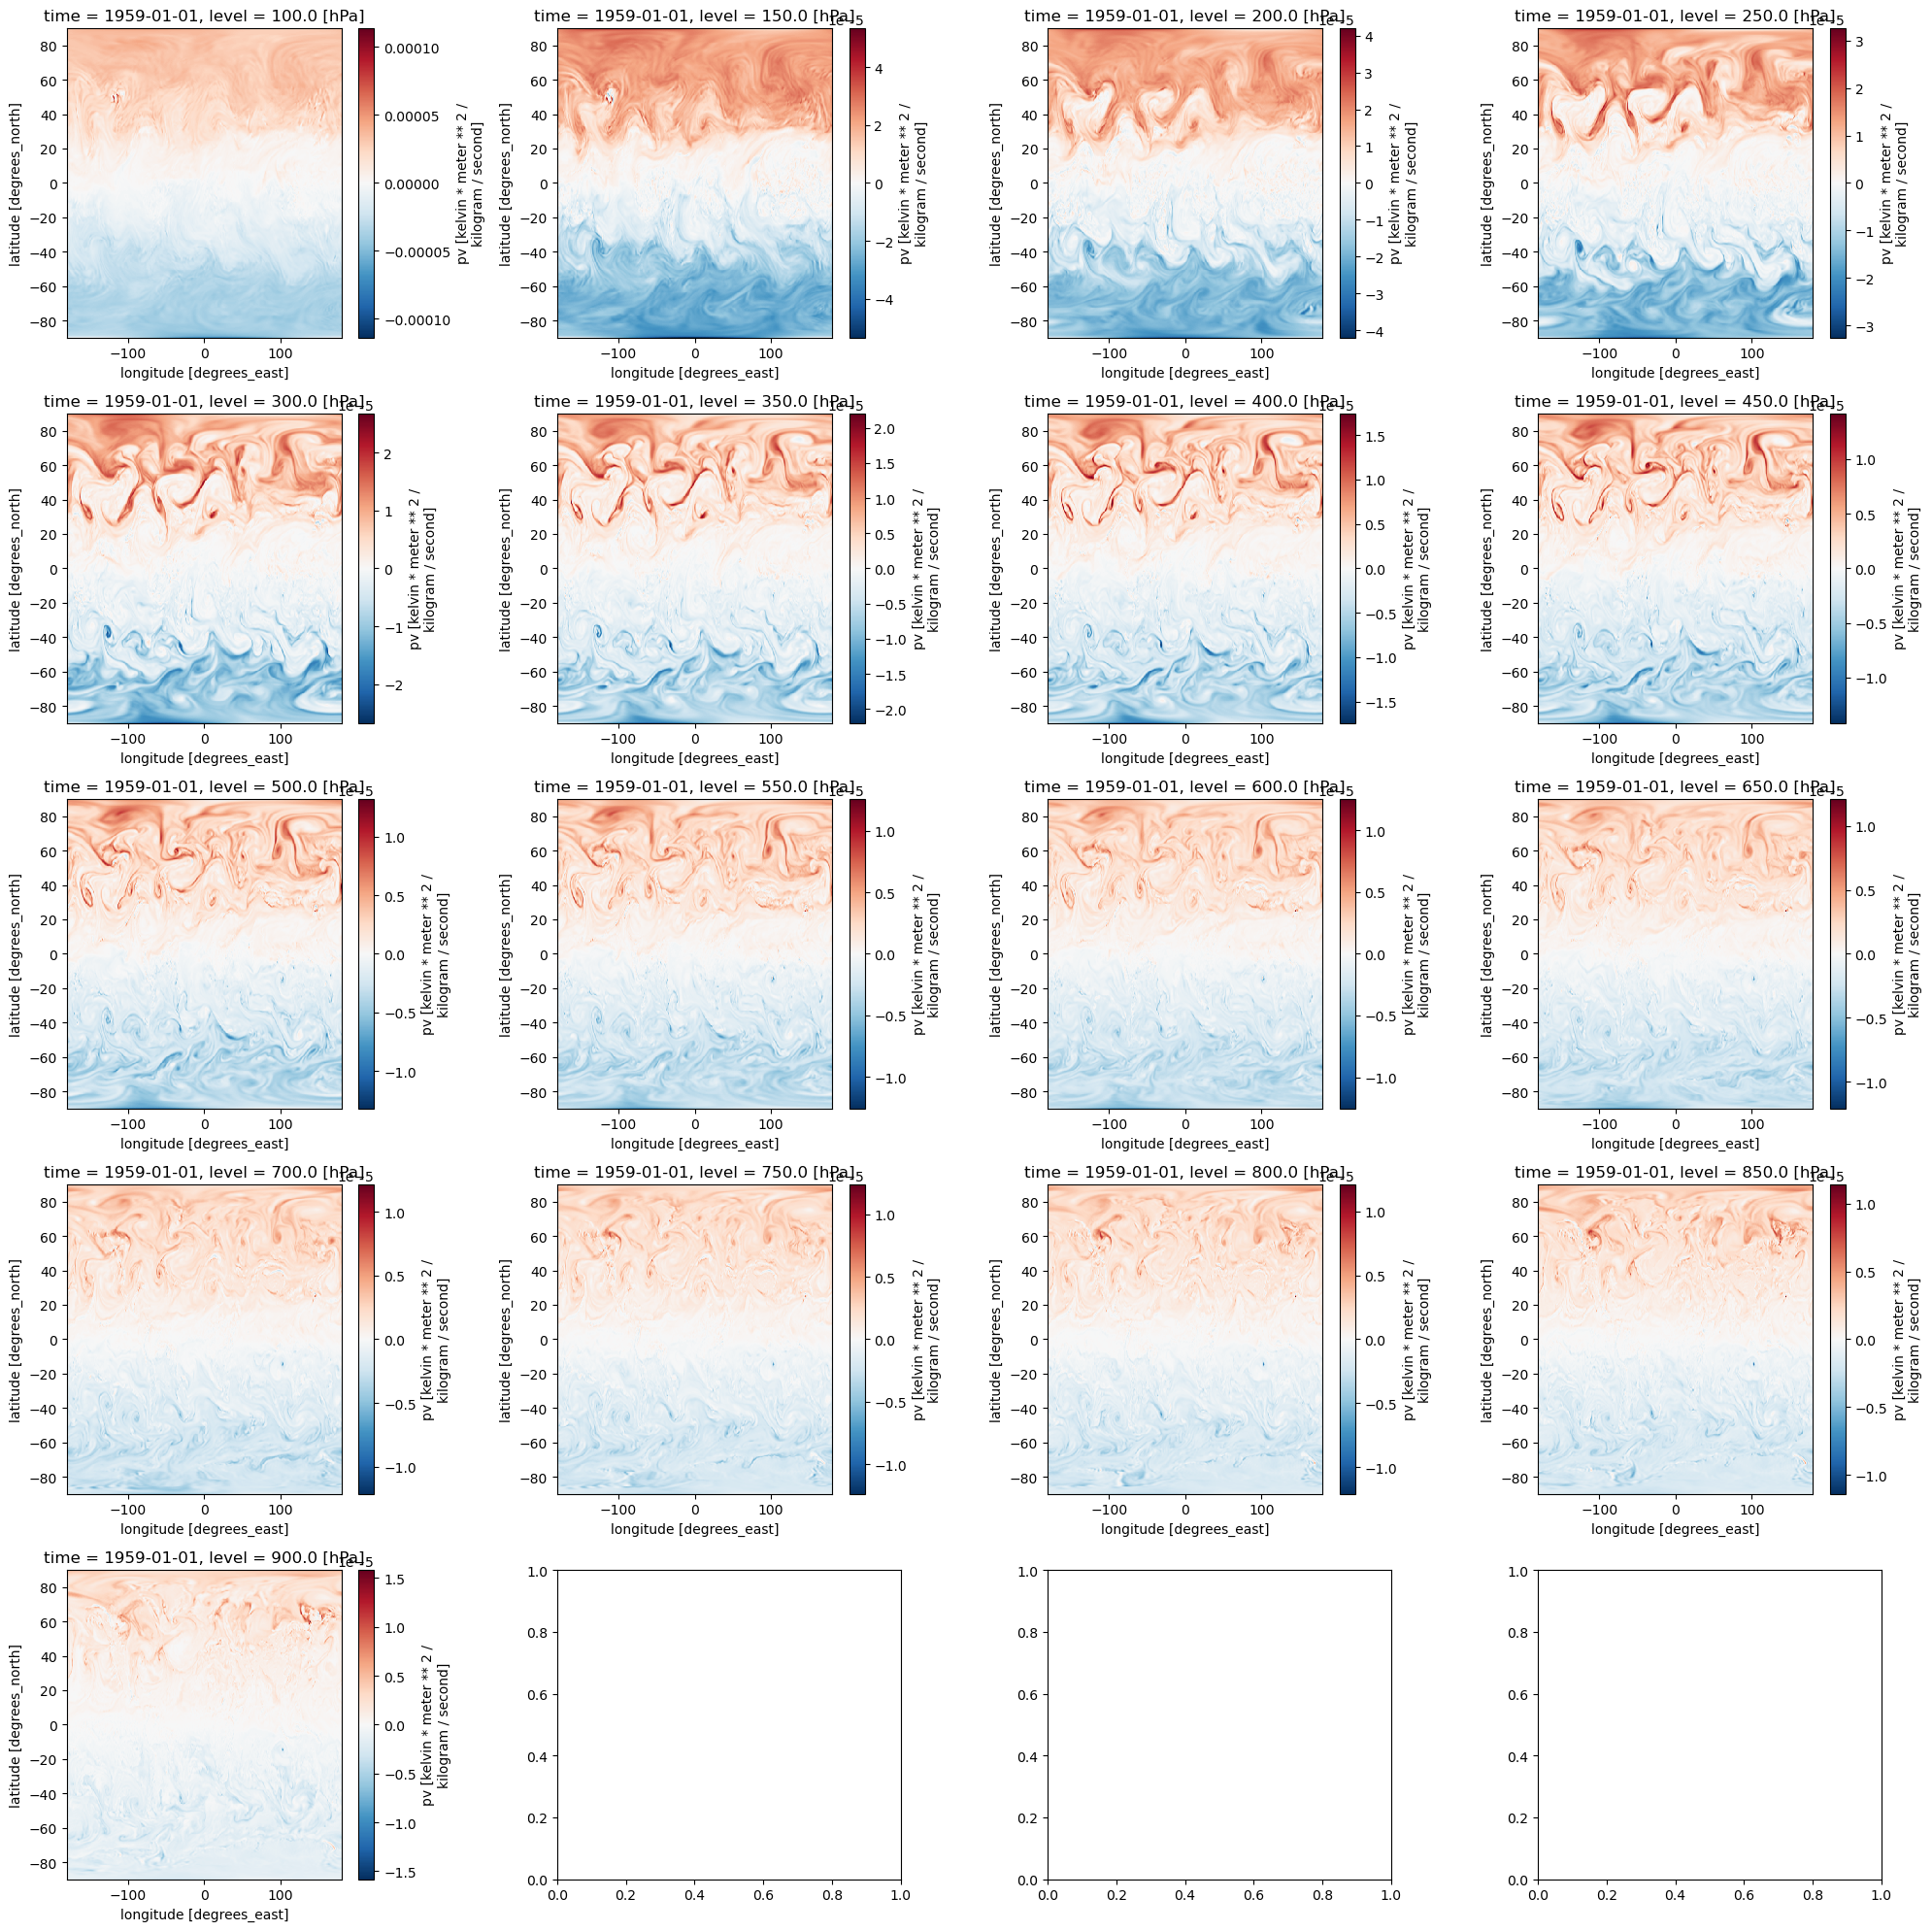

In [21]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20], tight_layout=True)
axes = axes.flatten()
k = 0
for k in range(17):
    ds["pv"].isel(level=k, time=0).plot(ax=axes[k])
    k += 1

In [ ]:
def create_plot(to_plot, titles, levels, twolevel=False, startindex=-1):
    # Figure
    transform = ccrs.PlateCarree()
    projection = transform
    if twolevel:
        fig, axes = plt.subplots(
            2,
            int(len(to_plot) / 2),
            subplot_kw={"projection": projection}, constrained_layout=True #, figsize=(6 * len(to_plot) // 2, 13)
        )
    else:
        fig, axes = plt.subplots(
            1, len(to_plot), subplot_kw={"projection": projection}, constrained_layout=True
        )
    axes = np.atleast_1d(axes)
    axes = axes.flatten()

    # Add coastline and boarders
    coastline = feat.NaturalEarthFeature(
        "physical", "coastline", "10m", edgecolor="black", facecolor="none"
    )
    borders = feat.NaturalEarthFeature(
        "cultural",
        "admin_0_boundary_lines_land",
        "10m",
        edgecolor="grey",
        facecolor="none",
    )
    plt_rej = []
    cbar = [None] * len(to_plot)
    for j in range(len(to_plot)):
        ax = axes[j]
        plt_rej.append(
            ax.contourf(
                to_plot[j]["lon"],
                to_plot[j]["lat"],
                to_plot[j].isel(time=startindex),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
        )

        ax.add_feature(coastline)
        ax.add_feature(borders)
        ax.set_xmargin(0)
        ax.set_ymargin(0)
        ax.set_title(f"Day {startindex}, {titles[j]}, g.a : {np.mean(to_plot[j][startindex]):.2f}")

        cbar[j] = fig.colorbar(plt_rej[j], ax=ax,fraction=0.046, pad=0.04)

    def animate_all(i):
        global plt_rej
        for j in range(len(to_plot)):
            ax = axes[j]
            for c in plt_rej[j].collections:
                c.remove()
            plt_rej[j] = ax.contourf(
                to_plot[j]["lon"],
                to_plot[j]["lat"],
                to_plot[j].isel(time=i),
                levels=levels[j],
                transform=transform,
                transform_first=True,
                # cmap=cmap,
                zorder=0,
            )
            ax.set_title(f"Day {i + 1}, {titles[j]}, g.a : {np.mean(to_plot[j][i]):.2f}")
            cbar[j] = fig.colorbar(plt_rej[j], cax=fig.axes[len(axes) + j])
        return plt_rej

    return fig, axes, plt_rej, animate_all

In [ ]:
# create yearly files containing u(700-75-925), compliant with Barripedro et. al (2022); Woollings (2010)

# f1 = IntProgress(min=0, max=len(YEARSPL) * 12)
# display(f1)
for year in YEARSPL:
    for month in range(1, 13):
        fn = filenamegeneric("Woollings", year, month)
        if os.path.isfile(fn):
            # f1.value += 1
            continue
        to_merge = []
        for d in DATERANGEPL[np.logical_and(DATERANGEPL.year == year, DATERANGEPL.month == month)]:    
            to_merge.extend(fncp(d))
        xr.open_mfdataset(
            to_merge, 
            drop_variables=[v for v in longname if v != "u"], 
            engine="scipy",
        ).sel(
            level=[700.0, 750.0, 800.0, 850.0, 900.0]
        ).to_netcdf(fn)
        # f1.value += 1

In [ ]:
longname = {
    "u": "U-component of wind",
    "v": "V-component of wind",
    "w": "W-component of wind",
    "z": "Geopotential",
    "t": "Temperature",
    "vo": "Relative vorticity",
    "q": "Specific humidity",
    "r": "relative humidity"
    
}
variablemap = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for var in ["u", "v", "vo"] 
    for lev in range(700, 901, 50)
}
var = "z"
vm2 = {
    f"{var}{lev}": [var, "PL", lev, f"{longname[var]} at {lev} hPa"] 
    for lev in [300, 500]
}

variablemap.update(vm2)
variablemap["t850"] = ["t", "PL", 850, f"{longname['t']} at 850 hPa"]

In [ ]:
ds = xr.open_mfdataset(fn(DATERANGEML[0], which="ML")[:1], combine="nested", concat_dim="time")
ds["P"] = (ds["hybm"] * ds["PS"] + ds["hyam"]).isel(lev_2=0).drop("lev_2").rename({"nhym": "lev"})
ds["P"].attrs["units"] = "Pa"
ds["T"].attrs["units"] = "celsius"
ds = ds.isel(lat=range(1, len(ds.lat) -1)).metpy.quantify()
ds["THETA"] = mcalc.potential_temperature(ds["P"], ds["T"])
ds["PV"] = mcalc.potential_vorticity_baroclinic(ds["THETA"], ds["P"], ds["U"], ds["V"], x_dim=3, y_dim=2, vertical_dim=1)

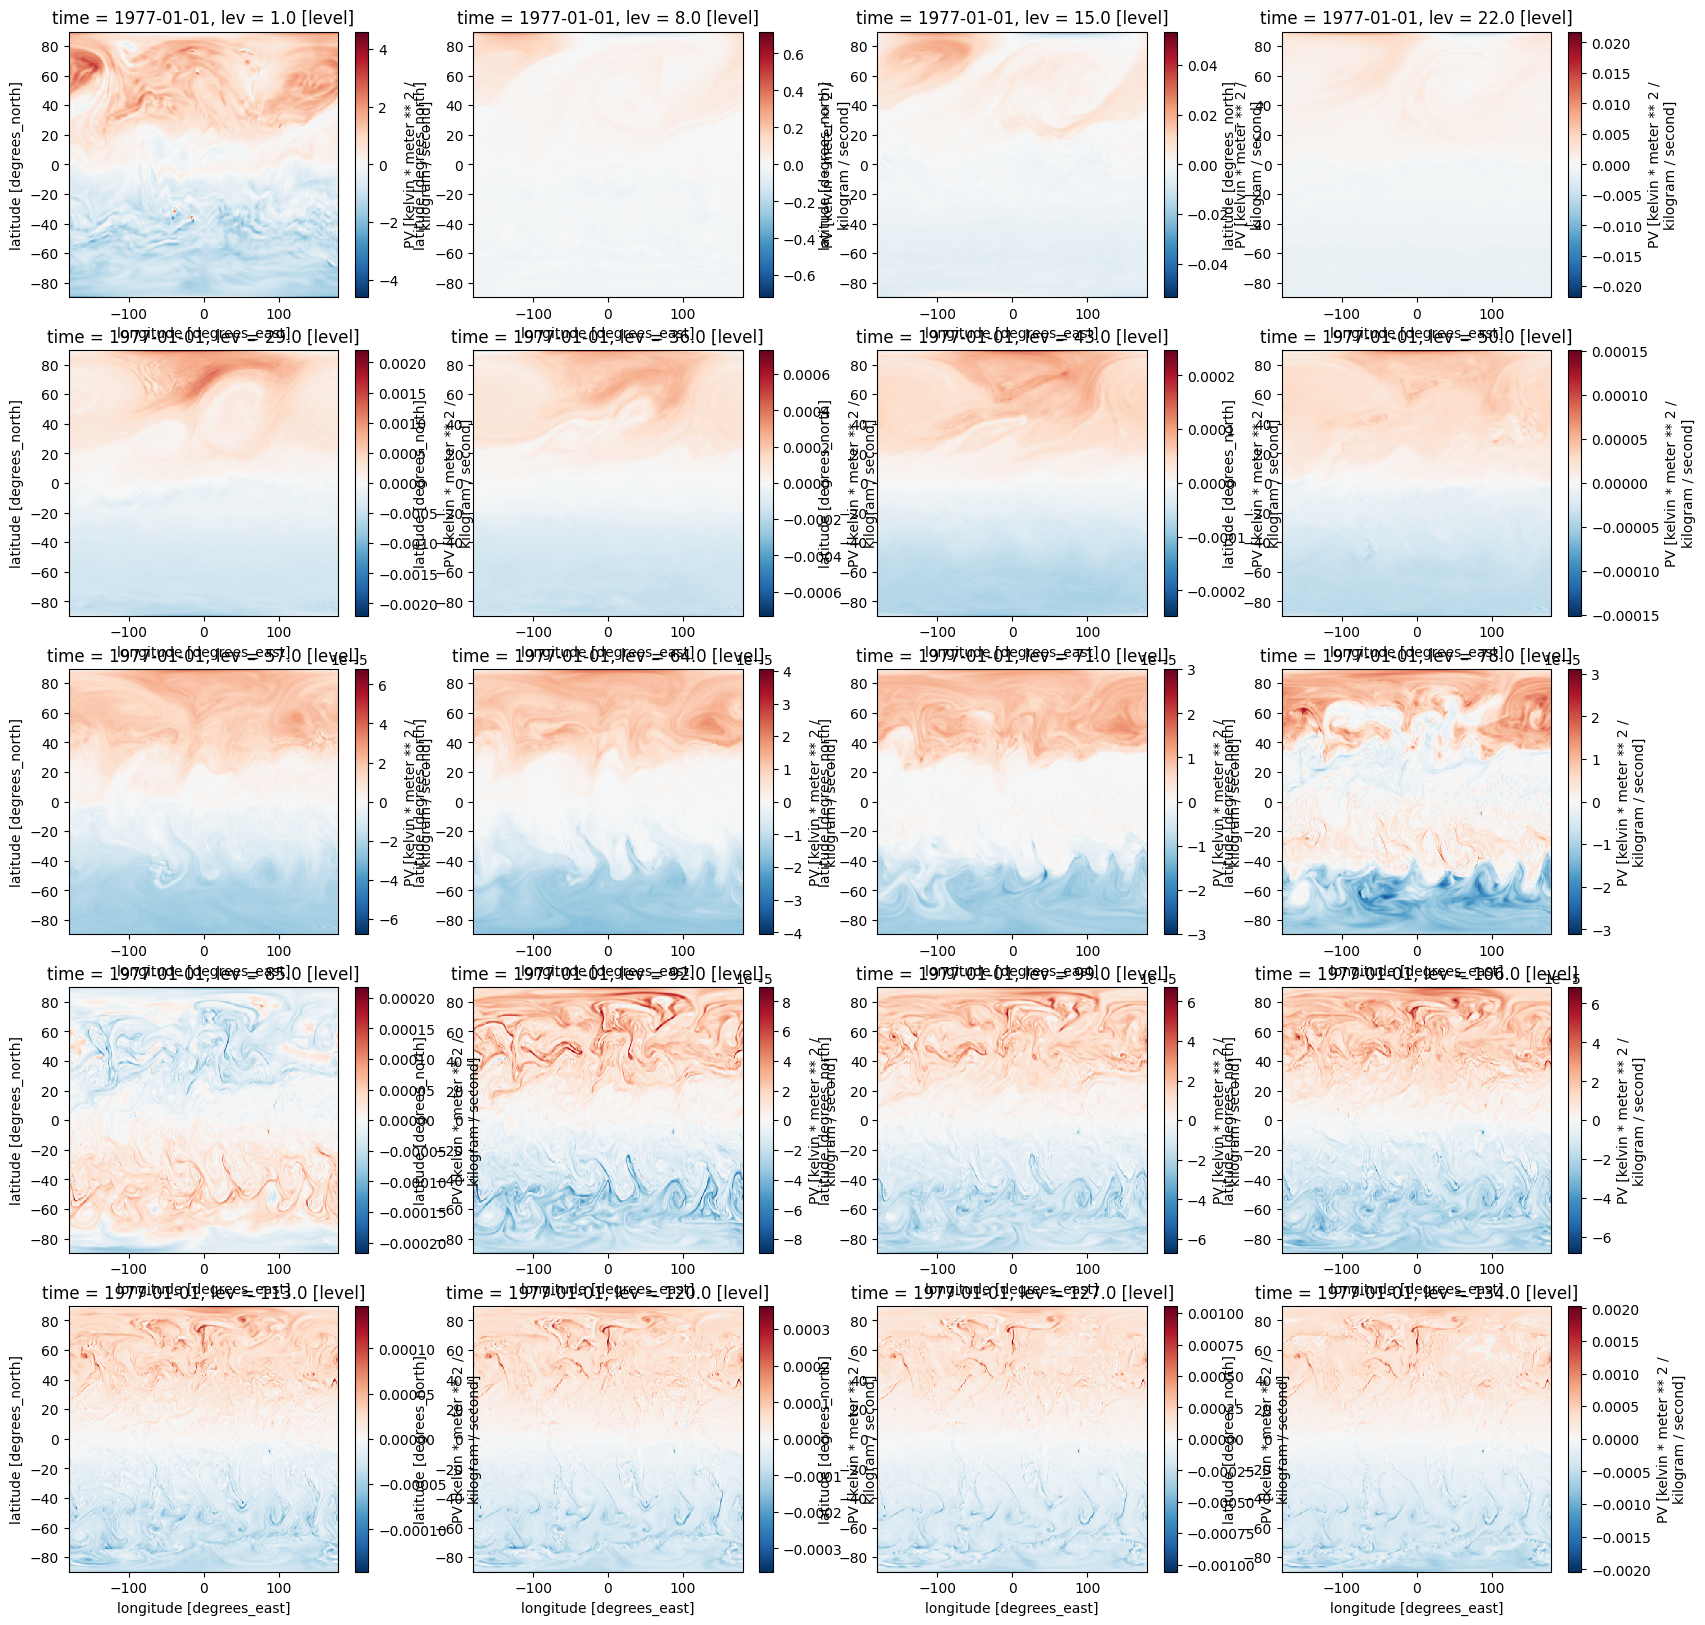

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=[20, 20])
axes = axes.flatten()
for l, k in enumerate(range(0, 137, int(137/20) + 1)):
    ds["PV"].isel(lev=k, time=0).plot(ax=axes[l])

In [ ]:
dims = ["time", "lat", "lon"]
ds["U_2PVU"] = xr.DataArray(np.empty([len(ds["T"].coords[dim]) for dim in dims]), dims=dims, coords={dim: ds["T"].coords[dim] for dim in dims})
ds["V_2PVU"] = ds["U_2PVU"].copy()
for ti, t in enumerate(ds.time):
    this_ds = ds.isel(time=ti)
    for w in ["U", "V"]:
        ds[f"{w}_2PVU"][ti, :, :] = minterpolate.interpolate_to_isosurface(this_ds["PV"].values, this_ds[w].values, 2e-6)

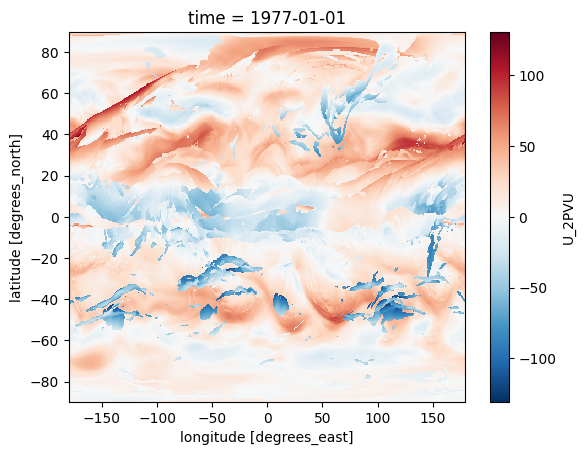

In [ ]:
ds["U_2PVU"].plot()

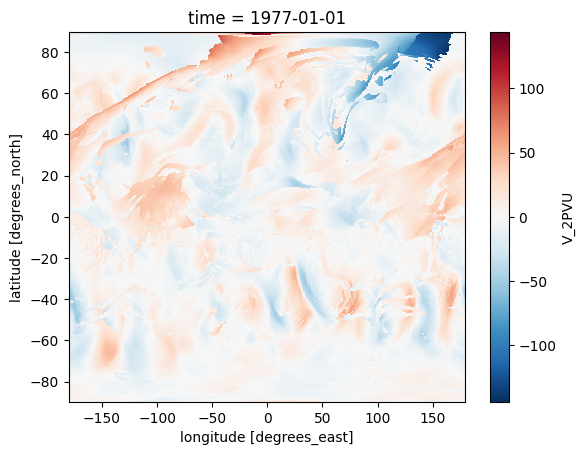

In [ ]:
ds["V_2PVU"].plot()